# Imports set up rendering

In [1]:
#@title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true "
    "--xla_gpu_triton_gemm_any=True "
    # "--xla_gpu_enable_async_collectives=true "
    # "--xla_gpu_enable_latency_hiding_scheduler=true "
    # "--xla_gpu_enable_highest_priority_async_stream=true "
)
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 1
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true " "--xla_gpu_triton_gemm_any=True "
)

Wed Oct 30 15:08:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:83:00.0 Off |                    0 |
| N/A   37C    P8             35W /  350W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%load_ext autoreload
%autoreload 2
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1
import functools
import jax
# jax.config.update("jax_enable_x64", True)

n_gpus = jax.device_count(backend="gpu")
print(f"Using {n_gpus} GPUs")
from typing import Dict
from brax import envs
import mujoco
import pickle
import warnings
import mediapy as media
import hydra
import jax.numpy as jp

from omegaconf import DictConfig, OmegaConf
from brax.training.agents.ppo import networks as ppo_networks
from brax import math as brax_math
from custom_brax import custom_ppo as ppo
from custom_brax import custom_wrappers
from custom_brax import custom_ppo_networks
from orbax import checkpoint as ocp
from flax.training import orbax_utils
from preprocessing.mjx_preprocess import process_clip_to_train
from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking
from utils.utils import *
from utils.fly_logging import log_eval_rollout

warnings.filterwarnings("ignore", category=DeprecationWarning)
# jax.config.update("jax_enable_x64", True)

from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra


Using 1 GPUs


/gscratch/portia/eabe/miniconda3/envs/stac-mjx-env/lib/python3.11/site-packages/wandb/analytics/sentry.py:90: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  self.hub = sentry_sdk.Hub(client)


# Load configs

In [86]:
# base_dir ='/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt'
base_dir ='/gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt'
run_cfg_list = sorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    print(n, run_cfg)


cfg_num = -1
cfg = OmegaConf.load(run_cfg_list[cfg_num])
run_id = int(run_cfg_list[cfg_num].parent.parent.stem.split('=')[1])
print(cfg.dataset.dname)
fig_dir = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/debug/figures')

0 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21354660/logs/run_config.yaml
1 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21354663/logs/run_config.yaml
2 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21355274/logs/run_config.yaml
3 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21355369/logs/run_config.yaml
4 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21355649/logs/run_config.yaml
5 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356039/logs/run_config.yaml
6 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356057/logs/run_config.yaml
7 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356081/logs/run_config.yaml
8 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356910/logs/run_config.yaml
9 /gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21364598/logs/run_config.yaml
10 /gscrat

In [84]:
dataset = cfg.dataset.dname
with initialize(version_base=None, config_path="configs"):
    cfg_temp=compose(config_name='config.yaml',overrides= [f"dataset={dataset}", f"train=train_{dataset}", "paths=walle", "version=ckpt", f'run_id={run_id}'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg_temp)
    
cfg.paths = cfg_temp.paths

In [87]:
for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)
env_cfg = cfg.dataset
env_args = cfg.dataset.env_args

cfg.paths.base_dir = cfg.paths.base_dir.parent / 'ckpt'
reference_path = cfg.paths.data_dir/ f"clips/all_clips_batch_interp.p"
# reference_path = cfg.paths.data_dir/ f"clips/{cfg.dataset['clip_idx']}"
reference_path.parent.mkdir(parents=True, exist_ok=True)

with open(reference_path, "rb") as file:
    # Use pickle.load() to load the data from the file
    reference_clip = pickle.load(file)
ref_data = np.concatenate([reference_clip.position,reference_clip.quaternion,reference_clip.joints], axis=-1)

# Load env

In [88]:
from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking, FlyRunSim, _bounded_quat_dist
# dataset = 'multiclip'

# with initialize(version_base=None, config_path="configs"):
#     cfg=compose(config_name='config.yaml',overrides= [f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", "paths=walle"],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg)


# env_args = cfg.dataset.env_args
envs.register_environment("fly_freejnt_clip", FlyTracking)
envs.register_environment("fly_freejnt_multiclip", FlyMultiClipTracking)
envs.register_environment("fly_run_policy", FlyRunSim)
# cfg.dataset.env_args.mjcf_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_viz_only.xml'
# cfg.dataset.env_args.mjcf_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast.xml'
print(cfg.train.env_name)
cfg.dataset.env_args.iterations = 12
cfg.dataset.env_args.ls_iterations = 12
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **cfg.dataset.env_args,
)

fly_run_policy
self._steps_for_cur_frame: 1


In [89]:
rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
    
# rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
# define the jit reset/step functions
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
state = jit_reset(jax.random.PRNGKey(0))


# Test inference

In [90]:
from orbax import checkpoint as ocp
from flax.training import orbax_utils
import optax

In [91]:
model_path = Path(cfg.paths.ckpt_dir/f"{run_id}")
# model_path = '/gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/debug/ckpt'
# max_ckpt = cfg.train.restore_checkpoint
##### Get all the checkpoint files #####
ckpt_files = sorted([Path(f.path) for f in os.scandir(model_path) if f.is_dir()])
max_ckpt = ckpt_files[-1].as_posix()
env_args = cfg.dataset.env_args
print(max_ckpt)

/gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21750716/ckpt/21750716/010


In [93]:
def policy_params_fn(num_steps, make_policy, params, policy_params_fn_key, model_path=model_path):
  # save checkpoints
  print(params[1].policy)
#   orbax_checkpointer = ocp.PyTreeCheckpointer()
#   save_args = orbax_utils.save_args_from_target(params)
#   path = Path('/gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/debug/ckpt') / f'{num_steps}'
#   orbax_checkpointer.save(path, params, force=True, save_args=save_args)
  
if  ('network_type' in cfg.train) and (cfg.train['network_type'] is not None) and ('encoderdecoder' in cfg.train['network_type']):
    network_type = custom_ppo_networks.make_encoderdecoder_ppo_networks
    network_mask = {'params': {'encoder': 'learned', 'decoder': 'frozen', 'bottleneck':'learned'}}
else: 
    network_type = custom_ppo_networks.make_intention_ppo_networks
    network_mask = {'params': {'encoder': 'learned', 'latent':'learned','decoder': 'frozen'}}

def create_mask(network_mask):
    from custom_brax.custom_losses import PPONetworkParams
    mask = network_mask
    value = {'params': 'learned'}
    return PPONetworkParams(mask,value)
        
episode_length = (env_args.clip_length - 50 - env_args.ref_len) * env._steps_for_cur_frame
print(f"episode_length {episode_length}")

train_fn = functools.partial(
            ppo.train,
            num_envs=cfg.train["num_envs"],
            num_timesteps=0,
            num_evals=1,
            num_resets_per_eval=cfg.train['num_resets_per_eval'],
            reward_scaling=cfg.train['reward_scaling'],
            episode_length=episode_length,
            normalize_observations=True,
            action_repeat=cfg.train['action_repeat'],
            clipping_epsilon=cfg.train["clipping_epsilon"],
            unroll_length=cfg.train['unroll_length'],
            num_minibatches=cfg.train["num_minibatches"],
            num_updates_per_batch=cfg.train["num_updates_per_batch"],
            discounting=cfg.train['discounting'],
            learning_rate=cfg.train["learning_rate"],
            kl_weight=cfg.train["kl_weight"],
            entropy_cost=cfg.train['entropy_cost'],
            batch_size=cfg.train["batch_size"],
            seed=cfg.train['seed'],
            network_factory=functools.partial(
                network_type,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            ),
            restore_checkpoint_path=max_ckpt,
            freeze_fn=None if (cfg.train['freeze_decoder'] == False) else functools.partial(create_mask,network_mask=network_mask),
        )

make_inference_fn, params, _= train_fn(environment=env,)
params2 = (params[0],params[1].policy)
policy_params = (params[0],params[1].policy)
# Env_steps = params[2]
jit_inference_fn = jax.jit(make_inference_fn(policy_params, deterministic=True))

episode_length 946


In [14]:
env._n_clips, env._clip_length

(1, 1001)

In [95]:
policy_data = ioh5.load('/gscratch/portia/eabe/biomech_model/Flybody/datasets/Tuthill_data/Torque_control_multiclip_21546067.h5')

In [96]:
rollout_data = {'clip{:02d}'.format(n): {} for n in range(env._n_clips)}
# for n in range(env._n_clips):
n = 0
# reset_rng, act_rng = jax.random.split(policy_params_fn_key)
rng = jax.random.PRNGKey(1)
reset_rng, act_rng = jax.random.split(rng)
state = jit_reset(reset_rng)
state.info['clip_idx'] = n
print(state.info['clip_idx'])
rollout = [state]
# rollout_len = env_args["clip_length"]*int(rollout_env._steps_for_cur_frame)
rollout_len = env._clip_length
new_qpos = jp.array(policy_data['qposes'][0])
new_ctrl = jp.array(policy_data['ctrl'][0])
new_commands = jp.diff(policy_data['qposes'][0][:,:2],axis=0,prepend=0)
ctrl_all = []
for i in range(rollout_len):
    _, act_rng = jax.random.split(act_rng)
    # state = state.replace(pipeline_state=state.pipeline_state.replace(qpos=new_qpos[i]))
    # new_info = state.info
    # new_info['command'] = jp.array([1,1,0])
    # state = state.replace(info=new_info)
    obs = state.obs
    ctrl, extras = jit_inference_fn(obs, act_rng)
    # ctrl = new_ctrl[i]
    # ctrl = jp.zeros((env._nu))
    state = jit_step(state, ctrl)

    ctrl_all.append(ctrl.copy())
    rollout.append(state)
rollout2 = [state.pipeline_state for state in rollout]
rollout_data['clip{:02d}'.format(n)]['qposes'] = jp.stack([state.qpos for state in rollout2])
rollout_data['clip{:02d}'.format(n)]['qvels'] = jp.stack([state.qvel for state in rollout2])
rollout_data['clip{:02d}'.format(n)]['ctrl'] = jp.stack(ctrl_all)
# rollout_data['clip{:02d}'.format(n)]['sensordata'] = jp.stack([state.sensordata for state in rollout2])


0


In [ ]:
pixels = rollout_env.render(rollout[200].pipeline_state, camera='track1', width=480, height=480, scene_option=scene_option)
media.show_image(pixels)

In [97]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

pixels = rollout_env.render(rollout2, camera='track1', width=480, height=480, scene_option=scene_option)
media.show_video(pixels,fps=50)

In [ ]:
ctrl_all = jp.array(ctrl_all)
model_path = "/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_fastviz.xml"
spec = mujoco.MjSpec()
spec = spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
# first_joint.delete()
root = spec.compile()
root.opt.solver = {
    "cg": mujoco.mjtSolver.mjSOL_CG,
    "newton": mujoco.mjtSolver.mjSOL_NEWTON,
}[cfg.dataset.env_args.solver.lower()]
root.opt.iterations = env_args.iterations
root.opt.ls_iterations = env_args.ls_iterations
root.opt.timestep = env_args.physics_timestep
root.opt.jacobian = 0
data = mujoco.MjData(root)
data.qpos = qposes_rollout[0]
mujoco.mj_forward(root, data)
n_frames = ctrl_all.shape[0]
height = 512
width = 512
frames = []
fps = 1/env.dt
times = []
sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

qpos_all,rollout,ncon_all = [],[],[]
with mujoco.Renderer(root, height, width) as renderer:
    for i in range(n_frames):
        data.ctrl = ctrl_all[i].copy()
        # data.qpos = qposes_rollout[i].copy()
        while data.time < i/fps:
            mujoco.mj_step(root, data)
            sensordata.append(data.sensordata.copy())
        times.append(data.time)
        renderer.update_scene(data,camera='track1',scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)
        qpos_all.append(data.qpos.copy())
        ncon_all.append(data.ncon)
        rollout.append(data)

media.show_video(frames, fps=50)


In [ ]:
end_eff = [
'claw_T1_left',
'claw_T1_right',
'claw_T2_left',
'claw_T2_right',
'claw_T3_left',
'claw_T3_right',
]

In [ ]:
# 1 (mg cm) / (s^2) = 1.0 × 10-8 newtons

In [ ]:
N = 100
sdata = 1e-8*(np.stack(sensordata).reshape(-1,6,3)) # Time x end_eff x xyz, x=forward
sdata = np.apply_along_axis(lambda m: np.convolve(m, np.ones(N)/N, mode='full'), axis=0, arr=sdata)

fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
for n in range(len(end_eff)):
    ax = axs[n]
    ax.plot(sdata[:,n,0])
    ax.plot(sdata[:,n,1])
    ax.plot(sdata[:,n,2])
# plt.plot(sdata[:,:,2])

# Test reward functions

In [ ]:
env._reference_clip.quaternion[0], reference_clip.quaternion[0],state.pipeline_state.qpos[3:7]
env._reference_clip.position[0], reference_clip.position[0],state.pipeline_state.qpos[:3]
env._reference_clip.joints[0], reference_clip.joints[0],state.pipeline_state.qpos[7:]


In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(100):
    # ctrl = ctrl_mpc[i]
    # ctrl = 5*jax.random.normal(rng, shape=(env.sys.nu,), dtype=jp.float32)
    ctrl = jp.zeros((env.sys.nu,))
    # dpos =jp.array([jp.sum(reference_clip.lin_vel_y[:i]*env.dt),0,0])
    # qpos_t = jp.concatenate((reference_clip.position[i]+dpos,reference_clip.quaternion[i], reference_clip.joints[i]))
    # qpos_t = jp.concatenate((reference_clip.position[i],reference_clip.quaternion[i], reference_clip.joints[i]))
    # qvel_t = jp.concatenate((reference_clip.velocity[i],reference_clip.angular_velocity[i], reference_clip.joints_velocity[i]))
    # pipeline = state.pipeline_state.replace(qpos=qpos_t, qvel=qvel_t)
    # pipeline = state.pipeline_state.replace(qpos=reference_clip.joints[i], qvel=reference_clip.joints_velocity[i])
    # state=state.replace(pipeline_state=pipeline)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

pixels = env.render(rollout, width=256, height=256, camera=1,scene_option=scene_option) 


In [ ]:
# print(env.time)
scene_option = mujoco.MjvOption()
scene_option.geomgroup[:] = [1, 1, 0, 0, 0, 0]
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
# pixels = env.render(rollout, width=1000, height=1000, camera=1,scene_option=scene_option) 
media.show_video(pixels, fps=50)

In [ ]:
_pos_reward_weight = 1
_joint_reward_weight = 1
_angvel_reward_weight = 1
_bodypos_reward_weight = 1
_endeff_reward_weight = 1
_quat_reward_weight = 1
_pos_scaling = 400.0
_joint_scaling = 0.25
_angvel_scaling = 0.5
_bodypos_scaling = 4.0
_endeff_scaling = 0.05
_quat_scaling = 500.0
clip_idx=0
rewards = {'pos':[],'joint':[], 'angvel':[], 'bodypos':[], 'endeff':[],'pos_reward':[], 'joint_reward':[], 'angvel_reward':[], 'bodypos_reward':[], 'endeff_reward':[], 'quat_distance':[], 'quat_reward':[]}
for cur_frame in range (1000): 
    data= rollout[cur_frame].pipeline_state
    
    quat_track = reference_clip.position[clip_idx,cur_frame]
    pos_distance = jp.sum((data.qpos[:3] - quat_track)**2)
    pos_reward = _pos_reward_weight * jp.exp(-_pos_scaling * pos_distance)
    
    quat_track = reference_clip.quaternion[clip_idx,cur_frame]
    quat_distance = jp.sum(_bounded_quat_dist(data.qpos[3:7], quat_track) ** 2)
    quat_reward = _quat_reward_weight * jp.exp(-_quat_scaling * quat_distance)
    
    joint_track = reference_clip.joints[clip_idx,cur_frame]
    joint_distance = jp.sum((data.qpos[7:] - joint_track) ** 2)
    joint_reward = _joint_reward_weight * jp.exp(-_joint_scaling * joint_distance)
    
    angvel_track = reference_clip.angular_velocity[clip_idx,cur_frame]
    angvel_distance = jp.sum((data.qvel[3:6] - angvel_track) ** 2)
    angvel_reward = _angvel_reward_weight * jp.exp(-_angvel_scaling * angvel_distance)
    
    bodypos_track = reference_clip.body_positions[clip_idx,cur_frame]
    bodypos_distance = jp.sum((data.xpos[env._body_idxs]- bodypos_track[env._body_idxs]).flatten()** 2)
    bodypos_reward = _bodypos_reward_weight * jp.exp(-_bodypos_scaling* bodypos_distance)
    
    endeff_track = reference_clip.body_positions[clip_idx,cur_frame]
    endeff_distance = jp.sum((data.xpos[env._endeff_idxs]- endeff_track[env._endeff_idxs]).flatten()** 2)
    endeff_reward = _endeff_reward_weight * jp.exp(-_endeff_scaling* endeff_distance)

        
    rewards['pos'].append(pos_distance)
    rewards['joint'].append(joint_distance)
    rewards['angvel'].append(angvel_distance)
    rewards['bodypos'].append(bodypos_distance)
    rewards['endeff'].append(endeff_distance)
    rewards['quat_distance'].append(quat_distance)
    
    rewards['pos_reward'].append(pos_reward)
    rewards['joint_reward'].append(joint_reward)
    rewards['angvel_reward'].append(angvel_reward)
    rewards['bodypos_reward'].append(bodypos_reward)
    rewards['endeff_reward'].append(endeff_reward)
    rewards['quat_reward'].append(quat_reward)
    


In [ ]:

fig, axs = plt.subplots(2,1, figsize=(10,10))
ax = axs[0]
# ax.plot(rewards['pos'], label='pos')
ax.plot(rewards['joint'], label='joint')
# ax.plot(rewards['angvel'], label='angvel')
ax.plot(rewards['bodypos'], label='bodypos')
ax.plot(rewards['endeff'], label='endeff')
ax.plot(rewards['quat_distance'], label='quat_distance')
ax.legend()

ax = axs[1]
# ax.plot(rewards['pos_reward'], label='pos_reward')
ax.plot(rewards['joint_reward'], label='joint_reward')
# ax.plot(rewards['angvel_reward'], label='angvel_reward')
ax.plot(rewards['bodypos_reward'], label='bodypos_reward')
ax.plot(rewards['endeff_reward'], label='endeff_reward')
ax.plot(rewards['quat_reward'], label='quat_reward')
ax.legend()
ax.set_ylim(-.1,1.1)



In [98]:
from jax.flatten_util import ravel_pytree
from brax import math as brax_math

rewards = {
    'summed_pos_distance_all': [],
    'target_pos_all': [],
    'tracking_lin_vel_all': [],
    'tracking_ang_vel_all': [],
    'ang_vel_xy_all': [],
    'lin_vel_z_all': [],
    'orientation_all': [],
    'torques_all': [],
    'action_rate_all': [],
    'stand_still_all': [],
    'termination_all': [],
    'foot_slip_all': [],
}
too_far_dist = 0.01
bad_pose_dist = 10.0
pos_reward_weight = 2.0 
tracking_lin_vel_weight = 0.0
tracking_ang_vel_weight = 0.0
lin_vel_z_weight = -5e-5
ang_vel_xy_weight = -1e-3
orientation_weight = 1.0
torques_weight = -0.0002
action_rate_weight = -0.01
stand_still_weight = -0.5
foot_slip_weight = -0.1
termination_weight = 1.0
pos_scaling = 200.0
linvel_scaling = 400.0
angvel_scaling = 4.0
ang_vel_xy_scaling = -1.0
lin_vel_z_scaling = -1.0
orientation_scaling = 5.0
torques_scaling = -1.0
action_rate_scaling = -1.0
stand_still_scaling = -1.0
foot_slip_scaling = -1.0
init_pos = env.sys.qpos0[:3]
target_trace = []
joint_distances = []
local_vel_all = []
term_conds = {
    'done': [],
    'nan': [],
    'fall': [],
    'too_far': [],
    'bad_pose': [],
    }
for cur_frame in range(len(rollout)): 
    data= rollout[cur_frame].pipeline_state
    
    info = state.info.copy()
    joint_angles = data.q[7:]
    joint_vel = data.qd[7:]
    x, xd = data.x, data.xd
    action = info['prev_ctrl']
    min_z, max_z = env._healthy_z_range
    is_healthy = jp.where(data.xpos[env._thorax_idx][2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.xpos[env._thorax_idx][2] > max_z, 0.0, is_healthy)
    fall = 1.0 - is_healthy
    # up = jp.array([0.0, 0.0, 1.0])
    # done = jp.int32(jp.dot(brax_math.rotate(up, x.rot[env._thorax_idx - 1]), up) < 0)

    reference_obs, proprioceptive_obs = env._get_obs(data, info, state.obs)
    obs = jp.concatenate([reference_obs, proprioceptive_obs])

    ##### Tracking position from velocity #####
    target_pos = env._init_pos + info['step']*jp.concatenate((info['command'][:2],jp.zeros(1)))*env.dt
    pos_distance = (data.qpos[:3] - target_pos)
    pos_reward = env._pos_reward_weight * jp.exp(
        -env._pos_scaling * jp.sum(pos_distance**2)
    )
    summed_pos_distance = jp.sum((pos_distance * jp.array([1.0, 1.0, 0.2])) ** 2)
    too_far = jp.where(summed_pos_distance > env._too_far_dist, 1.0, 0.0)
    ##### Tracking joint positions #####
    joint_distance = jp.sum((data.qpos[7:] - env._default_pose) ** 2)
    bad_pose = jp.where(joint_distance > env._bad_pose_dist, 1.0, 0.0)
    info['joint_distance'] = joint_distance
    joint_distances.append(joint_distance)
    target_trace.append(data.qpos[:3])
    # ##### Tracking quaternion flat orientation ######
    # quat_distance = jp.sum(
    #     _bounded_quat_dist(data.qpos[3:7], jp.array()) ** 2
    # )
    # quat_reward = env._quat_reward_weight * jp.exp(
    #     -env._quat_scaling * quat_distance
    # )
    
    
    from jax.flatten_util import ravel_pytree
    flattened_vals, _ = ravel_pytree(data)
    num_nans = jp.sum(jp.isnan(flattened_vals))
    nan = jp.where(num_nans > 0, 1.0, 0.0)
    done = jp.max(jp.array([nan, fall, too_far, bad_pose]))

    # foot contact data based on z-position
    foot_pos = data.site_xpos[env._endeff_idxs]  # pytype: disable=attribute-error
    foot_contact_z = foot_pos[:, 2] - env._foot_radius
    contact = foot_contact_z < 1e-3  # a mm or less off the floor
    contact_filt_mm = contact | state.info["last_contact"]
    contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]

    # Tracking of linear velocity commands (xy axes)
    local_vel = brax_math.rotate(xd.vel[0], brax_math.quat_inv(x.rot[0]))
    lin_vel_error = jp.sum(jp.square(info["command"][:2] - local_vel[:2]))
    lin_vel_reward = jp.exp(-env._linvel_scaling * lin_vel_error)
    info["bodypos_distance"] = lin_vel_error
    tracking_lin_vel = env._tracking_lin_vel_weight * lin_vel_reward
    local_vel_all.append(local_vel)
    # tracking_lin_vel = env._tracking_lin_vel_weight * env._reward_tracking_lin_vel(info['command'], x, xd)
    tracking_ang_vel = (
        env._tracking_ang_vel_weight
        * env._reward_tracking_ang_vel(info["command"], x, xd)
    )
    ang_vel_xy = jp.clip(env._ang_vel_xy_weight * env._reward_ang_vel_xy(xd),env._ang_vel_xy_scaling,0)
    lin_vel_z = jp.clip(env._lin_vel_z_weight * env._reward_lin_vel_z(xd),env._lin_vel_z_scaling,0)
    orientation = env._orientation_weight * jp.exp(-env._orientation_scaling*env._reward_orientation(x))
    torques = jp.clip(env._torques_weight * env._reward_torques(data.qfrc_actuator),env._torques_scaling,0)
    action_rate = jp.clip(env._action_rate_weight * env._reward_action_rate(
        action, info["prev_ctrl"]
    ), env._action_rate_scaling,0)
    stand_still = jp.clip(env._stand_still_weight * env._reward_stand_still(
        info["command"],
        joint_angles,
    ),env._stand_still_scaling,0)
    foot_slip = jp.clip(env._foot_slip_weight*env._reward_foot_slip(data, contact_filt_cm),env._foot_slip_scaling,0)
    termination = env._termination_weight * env._reward_termination(
        done, info["step"]
    )

    reward = (
        pos_reward
        + tracking_lin_vel
        + tracking_ang_vel
        + ang_vel_xy
        + lin_vel_z
        + orientation
        + torques
        + action_rate
        + stand_still
        + foot_slip
        + termination
    ) 
    
    term_conds['done'].append(done)
    term_conds['nan'].append(nan)
    term_conds['fall'].append(fall)
    term_conds['too_far'].append(too_far)
    term_conds['bad_pose'].append(bad_pose)
    rewards["summed_pos_distance_all"].append(summed_pos_distance)
    rewards['target_pos_all'].append(pos_reward)
    rewards['tracking_lin_vel_all'].append(tracking_lin_vel)
    rewards['tracking_ang_vel_all'].append(tracking_ang_vel)
    rewards['ang_vel_xy_all'].append(ang_vel_xy)
    rewards['lin_vel_z_all'].append(lin_vel_z)
    rewards['orientation_all'].append(orientation)
    rewards['torques_all'].append(torques)
    rewards['action_rate_all'].append(action_rate)
    rewards['stand_still_all'].append(stand_still)
    rewards['foot_slip_all'].append(foot_slip)
    rewards['termination_all'].append(termination)

joint_distances = jp.stack(joint_distances)
target_trace = jp.stack(target_trace)
local_vel_all = jp.stack(local_vel_all)
for key,val in rewards.items():
    rewards[key] = np.stack(val)
for key,val in term_conds.items():
    term_conds[key] = np.stack(val)

In [ ]:
print([key for key in rewards.keys()])

['summed_pos_distance_all', 'target_pos_all', 'tracking_lin_vel_all', 'tracking_ang_vel_all', 'ang_vel_xy_all', 'lin_vel_z_all', 'orientation_all', 'torques_all', 'action_rate_all', 'stand_still_all', 'termination_all', 'foot_slip_all']


In [99]:
termination_trace = jp.array([rollout[i].metrics['termination'] for i in range(len(rollout))])
tracking_error = jp.array([rollout[i].info['bodypos_distance'] for i in range(len(rollout))])
commands = jp.array([rollout[i].info['command'] for i in range(len(rollout))])
vels_direct = jp.array([rollout[i].pipeline_state.xd.vel[0] for i in range(len(rollout))])
vels_direct = jp.array([rollout[i].pipeline_state.xd.vel[0] for i in range(len(rollout))])
pos_all = jp.array([rollout[i].pipeline_state.xpos[1] for i in range(len(rollout))])

In [100]:
local_vel[:2],xd.vel[0,:2], info['command']

(Array([-0.00300008,  0.0004991 ], dtype=float32),
 Array([0.00108442, 0.00090601], dtype=float32),
 Array([-1.5994344,  0.       ,  0.       ], dtype=float32))

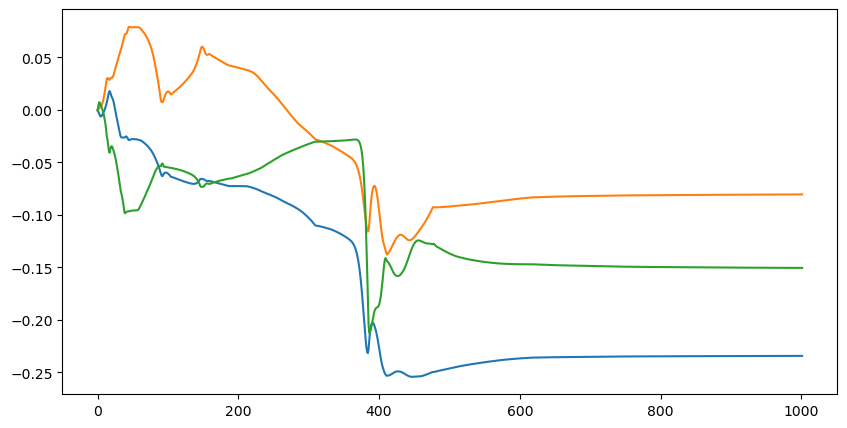

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
# for key, val in rewards.items():
#     ax.plot(val,label=key)
# for key, val in term_conds.items():
#     ax.plot(val,label=key)
# ax.legend(loc='upper right')
# ax.plot(rewards['target_pos_all'])
# ax.plot(rewards['summed_pos_distance_all'])
# ax.plot(rewards['tracking_linl_all'])
# ax.plot(jp.clip(rewards['lin_vel_z_all'],lin_vel_z_scaling,0))
# ax.plot(jp.clip(rewards['ang_vel_xy_all'],ang_vel_xy_scaling,0))
# ax.plot(rewards['orientation_all'])
# ax.plot(jp.clip(rewards['torques_all'],torques_scaling))
# ax.plot(jp.clip(rewards['action_rate_all'],stand_still_scaling))
# ax.plot(jp.clip(rewards['stand_still_all'],action_rate_scaling))
# ax.plot(np.clip(rewards['foot_slip_all'],foot_slip_scaling,0))
# ax.plot(rewards['termination_all'],'r',lw=2)
# ax.plot(jp.clip(sum(rewards.values()), 0.0, 10000.0),'k',lw=2)
# ax.plot(target_trace)
ax.plot(pos_all)
# ax.plot(jp.exp(-400*tracking_error[:100]))
# ax.plot(np.diff(commands[:,0]))
# ax.plot(jp.exp(-20*tracking_error))
# ax.plot(joint_distances)
# ax.plot(local_vel_all[:,:2])
# ax.axhline(y = jp.mean(vels_direct[:,:2],axis=0)[1])
# ax.plot(jp.mean(vels_direct[:,:2],axis=0))
# jp.mean(vels_direct[:,:2],axis=0)

In [100]:
local_vel[0]

Array(-0.06955665, dtype=float32)

In [76]:
tracking_error.shape

(1002, 3)

In [ ]:
render_path = Path(cfg.dataset.rendering_mjcf).parent / 'fruitfly_force_pair.xml'

In [ ]:
qposes_rollout = jp.array([data.qpos for data in rollout])
def f(x):
    if (not isinstance(x,str)):
        if (len(x.shape) != 1):
            return jax.lax.dynamic_slice_in_dim(
                x,
                0,
                qposes_rollout.shape[0],
            )
    return jp.array([])

ref_traj = jax.tree_util.tree_map(f, env._reference_clip)

repeats_per_frame = 1 #env._steps_for_cur_frame #int(1/(env._mocap_hz*env.sys.mj_model.opt.timestep))
spec = mujoco.MjSpec()
spec.from_file(render_path.as_posix())
thorax0 = spec.find_body("thorax-0")
first_joint0 = thorax0.first_joint()
if (env._free_jnt == False) & ('free' in first_joint0.name):
    qposes_ref = np.repeat(
        ref_traj.joints,
        repeats_per_frame,
        axis=0,
    )
    # qposes_ref = ref_traj.joints.copy()

    first_joint0.delete()
    thorax1 = spec.find_body("thorax-1")
    first_joint1 = thorax1.first_joint()
    first_joint1.delete()
elif env._free_jnt == True: 
    # qposes_ref = np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints])
    qposes_ref = np.repeat(
        np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints]),
        repeats_per_frame,
        axis=0,
    )
    
mj_model = spec.compile()

mj_model.opt.solver = {
    "cg": mujoco.mjtSolver.mjSOL_CG,
    "newton": mujoco.mjtSolver.mjSOL_NEWTON,
}["cg"]
mj_model.opt.iterations = cfg.dataset.env_args.iterations
mj_model.opt.ls_iterations = cfg.dataset.env_args.ls_iterations
mj_model.opt.timestep = env.sys.mj_model.opt.timestep

mj_data = mujoco.MjData(mj_model)

site_names = [
    mj_model.site(i).name
    for i in range(mj_model.nsite)
    if "-0" in mj_model.site(i).name
]
site_id = [
    mj_model.site(i).id
    for i in range(mj_model.nsite)
    if "-0" in mj_model.site(i).name
]
for id in site_id:
    mj_model.site(id).rgba = [1, 0, 0, 1]

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# save rendering and log to wandb
os.environ["MUJOCO_GL"] = "osmesa"
mujoco.mj_kinematics(mj_model, mj_data)
# renderer = mujoco.Renderer(mj_model, height=512, width=512)

frames = []
# render while stepping using mujoco
# video_path = f"{model_path}/{num_steps}.mp4"
# with imageio.get_writer(video_path, fps=50) as video:
with mujoco.Renderer(mj_model, height=512, width=512) as renderer:
    for qpos1, qpos2 in zip(qposes_rollout, qposes_ref):
        mj_data.qpos = np.append(qpos1, qpos2)
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(mj_data, camera=1, scene_option=scene_option)
        pixels = renderer.render()
        # video.append_data(pixels)
        frames.append(pixels)

In [ ]:
media.show_image(frames[0])

In [ ]:
media.show_video(frames, fps=50)


In [ ]:
mpc1_data = ioh5.load('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/fruitfly_qpos2_002ms.h5')
ctrl_mpc = jp.array(mpc1_data['ctrl'].T)
qpos_mpc = jp.array(mpc1_data['qpos'].T)

In [ ]:
model_path = ("/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fastball.xml")
spec = mujoco.MjSpec()
spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
first_joint.delete()
mj_model = spec.compile()

mj_model.opt.timestep = 0.0002
data = mujoco.MjData(mj_model)
mujoco.mj_forward(mj_model, data)
n_frames = 100
height = 240
width = 320
frames = []
fps = 1/.002
times = []
# sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
qpos_rollout = []
qvel_rollout = []
xpos_rollout = []
xquat_rollout = []
with mujoco.Renderer(mj_model, height, width) as renderer:
    for i in range(n_frames):
        # data.ctrl = ctrl_mpc[i]
        # data.qpos = np.concatenate([np.zeros(4),qpos_mpc[i]])
        # data.qpos = reference_clip.joints[i]
        data.qpos = np.concatenate([np.zeros(4),reference_clip.joints[i]])
        # mujoco.mj_forward(mj_model, data)
        # while data.time < i/fps:
        mujoco.mj_step(mj_model,data)
        qpos_rollout.append(data.qpos.copy())
        qvel_rollout.append(data.qvel.copy())
        xpos_rollout.append(data.xpos.copy())
        xquat_rollout.append(data.xquat.copy())
        # times.append(data.time)
        #     sensordata.append(data.sensor('force_tarsus_T1_left').data.copy())
        renderer.update_scene(data,camera=1,scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)
        
    
# # grab a trajectory
# for i in range(times.shape[0]):
#     data.ctrl = ctrl[i]
#     state = mujoco.mj_step(mj_model,data)
#     rollout.append(state)

media.show_video(frames, fps=50)


In [ ]:
qpos_rollout = jp.array(qpos_rollout)
qvel_rollout = jp.array(qvel_rollout)
xpos_rollout = jp.array(xpos_rollout)
xquat_rollout = jp.array(xquat_rollout)

In [ ]:
env.dt

In [ ]:
model_path = ("/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast.xml")
spec = mujoco.MjSpec()
spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
# first_joint.delete()
mj_model = spec.compile()

mj_model.opt.timestep = 0.0002
data = mujoco.MjData(mj_model)
mujoco.mj_forward(mj_model, data)
n_frames = 100
height = 240
width = 320
frames = []
fps = 1/.002
times = []
# sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
qpos_rollout = []
qvel_rollout = []
xpos_rollout = []
xquat_rollout = []

with mujoco.Renderer(mj_model, height, width) as renderer:
    for i in range(n_frames):

        data.qpos = np.concatenate([reference_clip.position[i],reference_clip.quaternion[i],reference_clip.joints[i]])
        mujoco.mj_step(mj_model,data)
        qpos_rollout.append(data.qpos.copy())
        qvel_rollout.append(data.qvel.copy())
        xpos_rollout.append(data.xpos.copy())
        xquat_rollout.append(data.xquat.copy())
        # times.append(data.time)
        #     sensordata.append(data.sensor('force_tarsus_T1_left').data.copy())
        renderer.update_scene(data,camera=1,scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)

In [ ]:
np.array(xpos_rollout)[:, :,2].min()

In [ ]:
media.show_image(frames[-1])

## Render ball mujoco

In [ ]:
mpc1_data = ioh5.load('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/fruitfly_qpos2_002ms.h5')
ctrl_mpc = jp.array(mpc1_data['ctrl'].T)
model_path = ("/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fastball.xml")
spec = mujoco.MjSpec()
spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
first_joint.delete()
root = spec.compile()
root.opt.timestep = 0.0002
data = mujoco.MjData(root)
n_frames = 200
height = 240
width = 320
frames = []
fps = 1/.002
times = []
sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

rollout = []
with mujoco.Renderer(root, height, width) as renderer:
    for i in range(n_frames):
        data.ctrl = ctrl_mpc[i]
        while data.time < i/fps:
            mujoco.mj_step(root, data)
        times.append(data.time)
        sensordata.append(data.sensor('force_tarsus_T1_left').data.copy())
        renderer.update_scene(data,camera=1,scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)
        rollout.append(data)
            
# # grab a trajectory
# for i in range(times.shape[0]):
#     data.ctrl = ctrl[i]
#     state = mujoco.mj_step(root,data)
#     rollout.append(state)

media.show_video(frames, fps=50)
# pixels = env.render(rollout, width=1000, height=1000, camera=3,scene_option=scene_option) 

In [ ]:
plt.plot(sensordata[:100])
plt.legend(['x','y','z'])

In [ ]:
env._ref_traj.body_quaternions.shape, data.xquat.shape

In [ ]:
rng, cmd_rng = jax.random.split(state.info["rng"], 2)

state.info["steps_taken_cur_frame"] += 1
state.info["cur_frame"] += jp.where(
    state.info["steps_taken_cur_frame"] == env._steps_for_cur_frame, 1, 0
)
state.info["steps_taken_cur_frame"] *= jp.where(
    state.info["steps_taken_cur_frame"] == env._steps_for_cur_frame, 0, 1
)
# physics step
data0 = state.pipeline_state
pipeline_state = env.pipeline_step(data0, action)
# motor_targets = env._default_pose + action * env._action_scale
# motor_targets = jp.clip(motor_targets, env.lowers, env.uppers)
# pipeline_state = env.pipeline_step(state.pipeline_state, motor_targets)
x, xd = pipeline_state.x, pipeline_state.xd


In [ ]:

min_z, max_z = env._healthy_z_range
is_healthy = jp.where(pipeline_state.xpos[env._thorax_idx][2] < min_z, 0.0, 1.0)
is_healthy = jp.where(pipeline_state.xpos[env._thorax_idx][2] > max_z, 0.0, is_healthy)
if env._terminate_when_unhealthy:
    healthy_reward = env._healthy_reward
else:
    healthy_reward = env._healthy_reward * is_healthy


In [ ]:

# obs = env._get_obs(pipeline_state, state.info, state.obs)
joint_angles = pipeline_state.q[7:]
joint_vel = pipeline_state.qd  ##### need to restrict to only legs

# foot contact data based on z-position
foot_pos = pipeline_state.site_xpos[
    env._endeff_idxs
]  # pytype: disable=attribute-error
foot_contact_z = foot_pos[:, 2] - env._foot_radius
contact = foot_contact_z < -.141  # a mm or less off the floor
# contact_filt_mm = contact | state.info["last_contact"]
# contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]


In [ ]:
foot_contact_z, contact

In [ ]:

# done if joint limits are reached or robot is falling
up = jp.array([0.0, 0.0, 1.0])
done = jp.dot(brax_math.rotate(up, x.rot[env._thorax_idx]), up) < 0
done |= jp.any(joint_angles < env.lowers)
done |= jp.any(joint_angles > env.uppers)
done |= pipeline_state.x.pos[env._thorax_idx, 2] < min_z
done |= pipeline_state.x.pos[env._thorax_idx, 2] > max_z

done